In [73]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import pytz
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from pickle import dump, load
import optuna
from sklearn.model_selection import cross_val_score
import joblib
from pickle import dump, load
from optuna.visualization import plot_optimization_history, plot_intermediate_values
import shap

In [2]:
path = "smell-pittsburgh-prediction-master/smell-pittsburgh-prediction-master/dataset/v2.1/esdr_raw"
list_of_files = [f for f in listdir(path) if isfile(join(path, f))]
sensor_raw_list = []
for f in list_of_files:
    sensor_raw_list.append(pd.read_csv(join(path, f)).set_index("EpochTime"))

In [3]:
lst = []
for df in sensor_raw_list:
    df.index = pd.to_datetime(df.index, unit="s", utc=True)
    lst.append(df)
full_df = pd.concat(lst, axis=1)

In [35]:
# # %pip install dataframe_image
# import dataframe_image as dfi
# # full_df
# full_df.drop(full_df.columns[[0, 1]], axis=1, inplace=True)

# dfi.export(full_df.head(),"sensordataframe.png",max_cols = 5)

In [4]:
def answer_preprocess_sensor(df_list):
    """
    Preprocess sensor data.

    """
    # Resample all the data frames.
    df_resample_list = []
    for df in df_list:
        # Convert the timestamp to datetime.
        df.index = pd.to_datetime(df.index, unit="s", utc=True)
#         df["year"] = df.index.year
#         df = df[(df["year"] >= lowerlim) & (df["year"] <= upperlim)]
        
        # Resample the timestamps by hour and average all the previous values.
        # Because we want data from the past, so label need to be "right".
        df_resample_list.append(df.resample("60Min", label="right").mean())
    
    # Merge all data frames.
    df = df_resample_list.pop(0)
    index_name = df.index.name
    while len(df_resample_list) != 0:
        # We need to use outer merging since we want to preserve data from both data frames.
        df = pd.merge_ordered(df, df_resample_list.pop(0), on=df.index.name, how="outer", fill_method=None)
        # Move the datetime column to index
        df = df.set_index(index_name)

    # Fill in the missing data with value -1.
    df = df.fillna(-1)
    return df

In [5]:
df_sensor = answer_preprocess_sensor(sensor_raw_list)

In [6]:
df_sensor

,3.feed_1.SO2_PPM,3.feed_1.H2S_PPM,3.feed_1.SIGTHETA_DEG,3.feed_1.SONICWD_DEG,3.feed_1.SONICWS_MPH,3.feed_1.PM25B_UG_M3..3.feed_1.PM25T_UG_M3..3.feed_1.PM25_640_UG_M3,3.feed_23.CO_PPM..3.feed_23.CO_PPB,3.feed_23.PM10_UG_M3,3.feed_24.PM10_UG_M3,3.feed_26.PM10B_UG_M3..3.feed_59665.PM10_640_UG_M3,...,3.feed_3.PM10B_UG_M3..3.feed_3.PM10_640_UG_M3,3.feed_11067.CO_PPB..3.feed_43.CO_PPB,3.feed_11067.NO2_PPB..3.feed_43.NO2_PPB,3.feed_11067.NOX_PPB..3.feed_43.NOX_PPB,3.feed_11067.NO_PPB..3.feed_43.NO_PPB,3.feed_11067.PM25T_UG_M3..3.feed_43.PM25T_UG_M3,3.feed_11067.SIGTHETA_DEG..3.feed_43.SIGTHETA_DEG,3.feed_11067.SONICWD_DEG..3.feed_43.SONICWD_DEG,3.feed_11067.SONICWS_MPH..3.feed_43.SONICWS_MPH,3.feed_5975.PM2_5
EpochTime,,,,,,,,,,,,,,,,,,,,,
2016-10-31 06:00:00+00:00,0.0,0.0,51.7,343.0,3.6,6.0,0.2,7.0,7.0,13.0,...,9.0,159.5,2.5,3.5,0.9,-1.0,46.8,17.0,2.1,0.0
2016-10-31 07:00:00+00:00,0.0,0.0,52.7,351.0,3.5,4.0,0.2,8.0,8.0,7.0,...,13.0,-1.0,2.7,3.8,1.1,5.0,46.1,10.0,2.2,5.0
2016-10-31 08:00:00+00:00,0.0,0.0,52.6,359.0,3.4,3.0,0.2,5.0,7.0,2.0,...,7.0,133.0,-1.0,-1.0,-1.0,9.0,22.4,43.0,4.6,9.0
2016-10-31 09:00:00+00:00,0.0,0.0,48.3,5.0,2.1,2.0,0.2,3.0,2.0,4.0,...,11.0,236.6,7.3,14.6,7.2,3.0,41.8,21.0,1.7,3.0
2016-10-31 10:00:00+00:00,0.0,0.0,31.1,41.0,2.2,3.0,0.2,5.0,5.0,5.0,...,10.0,269.3,8.2,13.1,4.8,9.0,42.0,50.0,1.4,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-11 01:00:00+00:00,-1.0,-1.0,-1.0,-1.0,-1.0,15.3,-1.0,-1.0,10.0,17.1,...,16.4,534.0,5.2,-1.0,-1.0,-1.0,43.8,125.0,0.8,12.0
2022-12-11 02:00:00+00:00,-1.0,-1.0,-1.0,-1.0,-1.0,15.8,-1.0,-1.0,9.0,18.6,...,17.0,498.8,6.4,-1.0,-1.0,-1.0,18.6,147.0,1.2,13.3
2022-12-11 03:00:00+00:00,-1.0,-1.0,-1.0,-1.0,-1.0,15.8,-1.0,-1.0,8.0,18.4,...,20.7,526.3,8.0,-1.0,-1.0,-1.0,12.6,148.0,1.0,14.1


In [7]:
def convert_wind_direction(df):
    """
    Convert wind directions to sine and cosine components.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The data frame that contains the wind direction data.
         
    Returns
    -------
    pandas.DataFrame
        The transformed data frame.
    """
    # Copy data frame to prevent editing the original one.
    df_cp = df.copy(deep=True)
    
    # Convert columns with wind directions.
    for c in df.columns:
        if "SONICWD_DEG" in c:
            df_c = df[c]
            df_c_cos = np.cos(np.deg2rad(df_c))
            df_c_sin = np.sin(np.deg2rad(df_c))
            df_c_cos.name += "_cosine"
            df_c_sin.name += "_sine"
            df_cp.drop([c], axis=1, inplace=True)
            df_cp[df_c_cos.name] = df_c_cos
            df_cp[df_c_sin.name] = df_c_sin
    return df_cp

In [8]:
smell_raw = pd.read_csv("smell-pittsburgh-prediction-master/smell-pittsburgh-prediction-master/dataset/v2.1/smell_raw.csv").set_index("EpochTime")

In [9]:
smell_raw.index = pd.to_datetime(smell_raw.index, unit="s", utc=True)

In [10]:
smell_raw.head(20)

,skewed_latitude,skewed_longitude,smell_value,smell_description,feelings_symptoms,additional_comments,zipcode
EpochTime,,,,,,,
2016-10-31 17:32:14+00:00,40.4293,-79.8720,1,NaN,NaN,NaN,15221
2016-10-31 17:42:47+00:00,40.3624,-79.9749,1,NaN,NaN,NaN,15227
2016-10-31 23:05:41+00:00,40.3275,-79.9606,1,NaN,NaN,NaN,15236
2016-10-31 23:23:00+00:00,40.4252,-79.8956,2,Woodsmoke,NaN,NaN,15218
2016-10-31 23:24:53+00:00,40.4237,-79.8964,3,Wood smoke,NaN,NaN,15218
2016-11-01 03:15:57+00:00,40.3627,-79.9729,3,Industrial,NaN,Penrated the house. Made me go outside to sm...,15227
2016-11-01 04:08:13+00:00,40.4195,-79.9384,5,Industrial,"Eye irritation, nose burns, headache, woke me up",This smell happens often. It's always at night...,15207
2016-11-01 12:01:47+00:00,40.3974,-80.0416,4,"Industrial, sulfur","Congestion, coughing",NaN,15216
2016-11-01 12:06:29+00:00,40.4308,-79.9527,2,Industrial smoke,NaN,NaN,15213


[Text(0.5, 0, 'Smell values'), Text(0, 0.5, 'Frequency')]

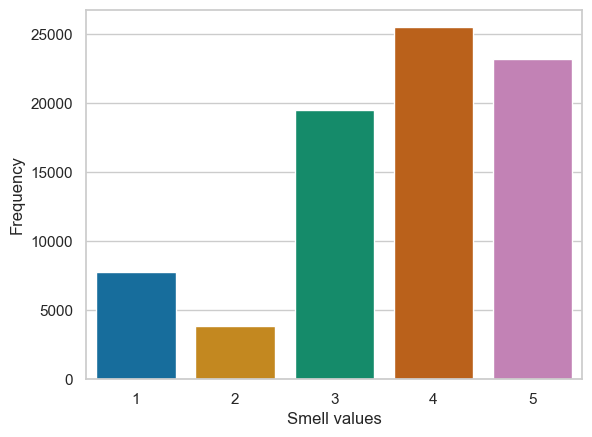

In [13]:
sns.set_theme(style="whitegrid")

ax = sns.countplot(data = smell_raw, x = "smell_value", palette = "colorblind")
ax.set(xlabel='Smell values', ylabel='Frequency')

In [14]:
def answer_preprocess_smell(df):
    """
    This function is the answer of task 4.
    Preprocess smell data.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The raw smell reports data.
         
    Returns
    -------
    pandas.DataFrame
        The preprocessed smell data.
    """
    # Copy the dataframe to avoid editing the original one.
    df = df.copy(deep=True)
    
    # Drop the columns that we do not need.
    df = df.drop(columns=["smell_description", "zipcode","skewed_latitude","skewed_longitude"])
    # Select only the reports within the range of 3 and 5.
    df = df[(df["smell_value"]>=3)&(df["smell_value"]<=5)]
    
    # Convert the timestamp to datetime.
    df.index = pd.to_datetime(df.index, unit="s", utc=True)
    
    # Resample the timestamps by hour and sum up all the future values.
    # Because we want data from the future, so label need to be "left".
    df = df.resample("60Min", label="left").sum()

    # Fill in the missing data with value 0.
    df = df.fillna(0)
    return df

In [15]:
df_smell = answer_preprocess_smell(smell_raw)

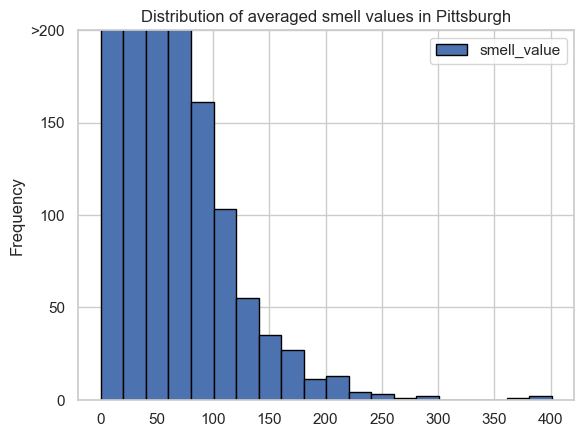

In [48]:
df_smell.plot(kind="hist", bins=20, ylim=(0,100), edgecolor="black",title = "Distribution of averaged smell values in Pittsburgh").set_yticks([0,50,100,150,200], labels=["0","50","100","150",">200"])


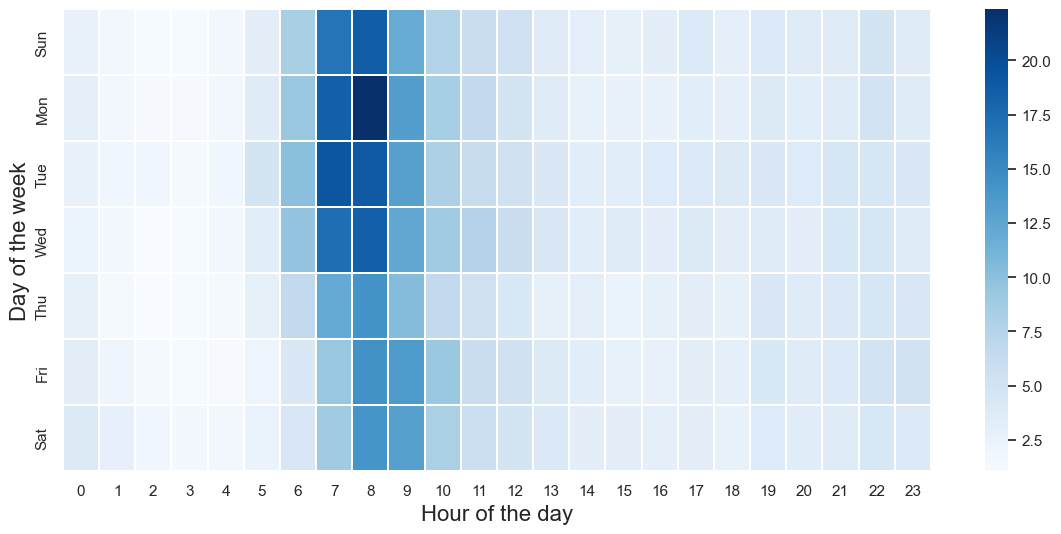

In [120]:
def is_datetime_obj_tz_aware(dt):
    """
    Find if the datetime object is timezone aware.
    
    Parameters
    ----------
    dt : pandas.DatetimeIndex
        A datatime index object.
    """
    return dt.tzinfo is not None and dt.tzinfo.utcoffset(dt) is not None


def plot_smell_by_day_and_hour(df):
    """
    Plot the average number of smell reports by the day of week and the hour of day.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The preprocessed smell data.
    """
    # Copy the data frame to prevent editing the original one.
    df = df.copy(deep=True)
    
    # Convert timestamps to the local time in Pittsburgh.
    if is_datetime_obj_tz_aware(df.index):
        df.index = df.index.tz_convert(pytz.timezone("US/Eastern"))
    else:
        df.index = df.index.tz_localize(pytz.utc, ambiguous="infer").tz_convert(pytz.timezone("US/Eastern"))
    
    # Compute the day of week and the hour of day.
    df["Day of the week"] = df.index.dayofweek
    df["Hour of the day"] = df.index.hour
    
    # Plot the graph.
    y_l = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]
    df_pivot = pd.pivot_table(df, values="smell_value", index=["Day of the week"], columns=["Hour of the day"], aggfunc=np.mean)
    f, ax = plt.subplots(figsize=(14, 6))
    plt.ylabel('Day of the week', fontsize=16)
    plt.xlabel('"Hour of the day', fontsize=16)
    sns.heatmap(df_pivot, annot=False, cmap="Blues", fmt="g", linewidths=0.1, yticklabels=y_l, ax=ax)
    
    
plot_smell_by_day_and_hour(df_smell)

In [22]:
def insert_previous_data_to_cols(df, n_hr=0):
    """
    Insert columns to indicate the data from the previous hours.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The preprocessed sensor data.
    n_hr : int
        Number of hours that we want to insert the previous sensor data.
         
    Returns
    -------
    pandas.DataFrame
        The transformed sensor data.
    """
    # Copy data frame to prevent editing the original one.
    df = df.copy(deep=True)

    # Add the data from the previous hours.
    df_all = []
    for h in range(1, n_hr + 1):
        # Shift the data frame to get previous data.
        df_pre = df.shift(h)
        # Edit the name to indicate it is previous data.
        # The orginal data frame already has data from the previous 1 hour.
        # (as indicated in the preprocessing phase of sensor data)
        # So we need to add 1 here.
        df_pre.columns += "_pre_" + str(h+1) + "h"
        # Add the data to an array for merging.
        df_all.append(df_pre)

    # Rename the columns in the original data frame.
    # The orginal data frame already has data from the previous 1 hour.
    # (as indicated in the preprocessing phase of sensor data)
    df.columns += "_pre_1h"

    # Merge all data.
    df_merge = df
    for d in df_all:
        # The join function merges dataframes by index.
        df_merge = df_merge.join(d)
        
    # Delete the first n_hr rows.
    # These n_hr rows have no data due to data shifting.
    df_merge = df_merge.iloc[n_hr:]
    return df_merge

In [23]:
df_sensor_example_out = insert_previous_data_to_cols(df_sensor, n_hr=2)

In [24]:
def answer_sum_current_and_future_data(df, n_hr=0):
    """
    This function is the answer of task 6.
    Sum up data in the current and future hours.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The preprocessed smell data.
    n_hr : int
         Number of hours that we want to sum up the future smell data.
         
    Returns
    -------
    pandas.DataFrame
        The transformed smell data.
    """
    # Copy data frame to prevent editing the original one.
    df = df.copy(deep=True)
    
    # Fast return if n_hr is 0
    if n_hr == 0: return df
    
    # Sum up all smell_values in future hours.
    # The rolling function only works for summing up previous values.
    # So we need to shift back to get the value in the future.
    # Be careful that we need to add 1 to the rolling window size.
    # Becasue window size 1 means only using the current data.
    # Parameter "closed" need to be "right" because we want the current data.
    df = df.rolling(n_hr+1, min_periods=1, closed="right").sum().shift(-1*n_hr)
    
    # Below is an alternative implementation of rolling.
    #indexer = FixedForwardWindowIndexer(window_size=n_hr+1)
    #df = df.rolling(indexer, min_periods=1).sum()
    
    # Delete the last n_hr rows.
    # These n_hr rows have wrong data due to data shifting.
    df = df.iloc[:-1*n_hr]
    return df

In [25]:
def compute_feature_label(df_smell, df_sensor, b_hr_sensor=0, f_hr_smell=0):
    """
    Compute features and labels from the smell and sensor data.
    
    Parameters
    ----------
    df_smell : pandas.DataFrame
        The preprocessed smell data.
    df_sensor : pandas.DataFrame
        The preprocessed sensor data.
    b_hr_sensor : int
        Number of hours that we want to insert the previous sensor data.
    f_hr_smell : int
        Number of hours that we want to sum up the future smell data.
    
    Returns
    -------
    df_x : pandas.DataFrame
        The features that we want to use for modeling.
    df_y : pandas.DataFrame
        The labels that we want to use for modeling.
    """
    # Copy data frames to prevent editing the original ones.
    df_smell = df_smell.copy(deep=True)
    df_sensor = df_sensor.copy(deep=True)
    
    # Replace -1 values in sensor data to NaN
    df_sensor[df_sensor==-1] = np.nan
    
    # Convert all wind directions.
    df_sensor = convert_wind_direction(df_sensor)
    
    # Scale sensor data and fill in missing values
    df_sensor = (df_sensor - df_sensor.mean()) / df_sensor.std()
    df_sensor = df_sensor.round(6)
    df_sensor = df_sensor.fillna(-1)
    
    # Insert previous sensor data as features.
    # Noice that the df_sensor is already using the previous data.
    # So b_hr_sensor=0 means using data from the previous 1 hour.
    # And b_hr_sensor=n means using data from the previous n+1 hours.
    df_sensor = insert_previous_data_to_cols(df_sensor, b_hr_sensor)
    
    # Sum up current and future smell values as label.
    # Notice that the df_smell is already the data from the future 1 hour.
    # (as indicated in the preprocessing phase of smell data)
    # So f_hr_smell=0 means using data from the future 1 hour.
    # And f_hr_smell=n means using data from the future n+1 hours.
    df_smell = answer_sum_current_and_future_data(df_smell, f_hr_smell)
    
    # Add suffix to the column name of the smell data to prevent confusion.
    # See the description above for the reason of adding 1 to the f_hr_smell.
    df_smell.columns += "_future_" + str(f_hr_smell+1) + "h"
    
    # We need to first merge these two timestamps based on the available data.
    # In this way, we synchronize the time stamps in the sensor and smell data.
    # This also means that the sensor and smell data have the same number of data points.
    df = pd.merge_ordered(df_sensor.reset_index(), df_smell.reset_index(), on=df_smell.index.name, how="inner", fill_method=None)
    
    # Sanity check: there should be no missing data.
    assert df.isna().sum().sum() == 0, "Error! There is missing data."
    
    
    # consider daytime
#     time_mask = (df['EpochTime'].dt.hour >= 5) & (df['EpochTime'].dt.hour <= 11)
    
#     df = df[time_mask]
    
    # Separate features (x) and labels (y).
    df_x = df[df_sensor.columns]
    df_y = df[df_smell.columns]
    


    # Add the hour of day and the day of week.
    dow_radian = df["EpochTime"].dt.dayofweek.copy(deep=True) * 2 * np.pi / 6.0
    tod_radian = df["EpochTime"].dt.hour.copy(deep=True) * 2 * np.pi / 23.0
    df_x.loc[:,"day_of_week_sine"] = np.sin(dow_radian)
    df_x.loc[:,"day_of_week_cosine"] = np.cos(dow_radian)
    df_x.loc[:,"hour_of_day_sine"] = np.sin(tod_radian)
    df_x.loc[:,"hour_of_day_cosine"] = np.cos(tod_radian)
    
    
    return df_x, df_y

In [26]:
def compute_feature_label_daytime(df_smell, df_sensor, b_hr_sensor=0, f_hr_smell=0):
    """
    Compute features and labels from the smell and sensor data.
    
    Parameters
    ----------
    df_smell : pandas.DataFrame
        The preprocessed smell data.
    df_sensor : pandas.DataFrame
        The preprocessed sensor data.
    b_hr_sensor : int
        Number of hours that we want to insert the previous sensor data.
    f_hr_smell : int
        Number of hours that we want to sum up the future smell data.
    
    Returns
    -------
    df_x : pandas.DataFrame
        The features that we want to use for modeling.
    df_y : pandas.DataFrame
        The labels that we want to use for modeling.
    """
    # Copy data frames to prevent editing the original ones.
    df_smell = df_smell.copy(deep=True)
    df_sensor = df_sensor.copy(deep=True)
    
    # Replace -1 values in sensor data to NaN
    df_sensor[df_sensor==-1] = np.nan
    
    # Convert all wind directions.
    df_sensor = convert_wind_direction(df_sensor)
    
    # Scale sensor data and fill in missing values
    df_sensor = (df_sensor - df_sensor.mean()) / df_sensor.std()
    df_sensor = df_sensor.round(6)
    df_sensor = df_sensor.fillna(-1)
    
    # Insert previous sensor data as features.
    # Noice that the df_sensor is already using the previous data.
    # So b_hr_sensor=0 means using data from the previous 1 hour.
    # And b_hr_sensor=n means using data from the previous n+1 hours.
    df_sensor = insert_previous_data_to_cols(df_sensor, b_hr_sensor)
    
    # Sum up current and future smell values as label.
    # Notice that the df_smell is already the data from the future 1 hour.
    # (as indicated in the preprocessing phase of smell data)
    # So f_hr_smell=0 means using data from the future 1 hour.
    # And f_hr_smell=n means using data from the future n+1 hours.
    df_smell = answer_sum_current_and_future_data(df_smell, f_hr_smell)
    
    # Add suffix to the column name of the smell data to prevent confusion.
    # See the description above for the reason of adding 1 to the f_hr_smell.
    df_smell.columns += "_future_" + str(f_hr_smell+1) + "h"
    
    # We need to first merge these two timestamps based on the available data.
    # In this way, we synchronize the time stamps in the sensor and smell data.
    # This also means that the sensor and smell data have the same number of data points.
    df = pd.merge_ordered(df_sensor.reset_index(), df_smell.reset_index(), on=df_smell.index.name, how="inner", fill_method=None)
    
    # Sanity check: there should be no missing data.
    assert df.isna().sum().sum() == 0, "Error! There is missing data."
    
    
    # consider daytime
    time_mask = (df['EpochTime'].dt.hour >= 5) & (df['EpochTime'].dt.hour <= 11)
    
    df = df[time_mask]
    
    # Separate features (x) and labels (y).
    df_x = df[df_sensor.columns]
    df_y = df[df_smell.columns]
    


    # Add the hour of day and the day of week.
    dow_radian = df["EpochTime"].dt.dayofweek.copy(deep=True) * 2 * np.pi / 6.0
    tod_radian = df["EpochTime"].dt.hour.copy(deep=True) * 2 * np.pi / 23.0
    df_x.loc[:,"day_of_week_sine"] = np.sin(dow_radian)
    df_x.loc[:,"day_of_week_cosine"] = np.cos(dow_radian)
    df_x.loc[:,"hour_of_day_sine"] = np.sin(tod_radian)
    df_x.loc[:,"hour_of_day_cosine"] = np.cos(tod_radian)
    
    
    return df_x, df_y

In [27]:
df_x,df_y = compute_feature_label(df_smell, df_sensor, b_hr_sensor=2, f_hr_smell=7)

C:\Users\nadaa\AppData\Local\Temp\ipykernel_39032\3369792383.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x.loc[:,"day_of_week_sine"] = np.sin(dow_radian)


In [28]:
df_x_daytime,df_y_daytime = compute_feature_label_daytime(df_smell, df_sensor, b_hr_sensor=2, f_hr_smell=7)

C:\Users\nadaa\AppData\Local\Temp\ipykernel_39032\1077727342.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x.loc[:,"day_of_week_sine"] = np.sin(dow_radian)


In [29]:
df_x

,3.feed_1.SO2_PPM_pre_1h,3.feed_1.H2S_PPM_pre_1h,3.feed_1.SIGTHETA_DEG_pre_1h,3.feed_1.SONICWS_MPH_pre_1h,3.feed_1.PM25B_UG_M3..3.feed_1.PM25T_UG_M3..3.feed_1.PM25_640_UG_M3_pre_1h,3.feed_23.CO_PPM..3.feed_23.CO_PPB_pre_1h,3.feed_23.PM10_UG_M3_pre_1h,3.feed_24.PM10_UG_M3_pre_1h,3.feed_26.PM10B_UG_M3..3.feed_59665.PM10_640_UG_M3_pre_1h,3.feed_26.PM25B_UG_M3..3.feed_26.PM25T_UG_M3..3.feed_59665.PM25_640_UG_M3_pre_1h,...,3.feed_28.SONICWD_DEG_cosine_pre_3h,3.feed_28.SONICWD_DEG_sine_pre_3h,3.feed_3.SONICWD_DEG_cosine_pre_3h,3.feed_3.SONICWD_DEG_sine_pre_3h,3.feed_11067.SONICWD_DEG..3.feed_43.SONICWD_DEG_cosine_pre_3h,3.feed_11067.SONICWD_DEG..3.feed_43.SONICWD_DEG_sine_pre_3h,day_of_week_sine,day_of_week_cosine,hour_of_day_sine,hour_of_day_cosine
0,-0.248729,-0.283268,-1.499083,-0.624622,-1.476542,-0.377849,-0.719919,-0.685898,-1.808120,-1.494236,...,0.263512,1.784749,-0.535558,1.350560,-1.246161,0.109588,0.000000,1.0,-2.449294e-16,1.000000
1,-0.248729,-0.283268,-1.412763,-0.710455,-1.789403,-0.377849,-0.628468,-0.562049,-1.090694,0.090943,...,1.072494,1.517632,0.522395,1.375163,0.386345,1.708488,0.866025,0.5,0.000000e+00,1.000000
2,-0.248729,-0.283268,1.161136,-0.967955,-0.537956,0.181120,-0.079759,-0.438200,-0.283590,0.566497,...,0.783056,1.677332,0.547253,1.367345,0.286386,1.719144,0.866025,0.5,2.697968e-01,0.962917
3,-0.248729,-0.283268,-0.063036,-0.967955,1.652078,0.181120,-0.354113,-0.376276,-0.193912,0.090943,...,0.943367,1.599628,0.522395,1.375163,0.534302,1.679319,0.866025,0.5,5.195840e-01,0.854419
4,-0.248729,-0.283268,1.545651,-1.010872,1.026354,0.181120,-0.171210,-0.562049,-0.462947,0.249461,...,1.605075,0.812302,0.669036,1.322546,0.794503,1.585868,0.866025,0.5,7.308360e-01,0.682553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53537,-1.000000,-1.000000,-1.000000,-1.000000,0.165984,-1.000000,-1.000000,-0.685898,-0.615400,-0.051723,...,1.153583,1.455536,0.785958,1.268490,-0.849902,1.276764,-0.866025,0.5,-9.422609e-01,-0.334880
53538,-1.000000,-1.000000,-1.000000,-1.000000,0.275485,-1.000000,-1.000000,-0.623974,-0.400172,0.170202,...,0.898535,1.623853,-1.222195,-0.644039,-0.796131,1.330355,-0.866025,0.5,-9.976688e-01,-0.068242
53539,-1.000000,-1.000000,-1.000000,-1.000000,0.541418,-1.000000,-1.000000,-0.685898,-0.373268,0.201905,...,0.711721,1.704436,-0.511021,1.359143,-1.129556,0.856267,-0.866025,0.5,-9.790841e-01,0.203456
53540,-1.000000,-1.000000,-1.000000,-1.000000,0.557061,-1.000000,-1.000000,-0.562049,-0.346365,0.217757,...,-0.259406,1.695824,-0.436453,1.382595,-1.097100,0.925279,-0.866025,0.5,-8.878852e-01,0.460065


In [30]:
df_y["smell_value_future_8h"]

0        11.0
1         8.0
2         8.0
3         8.0
4         8.0
         ... 
53537    40.0
53538    36.0
53539    32.0
53540    40.0
53541    32.0
Name: smell_value_future_8h, Length: 53542, dtype: float64

In [32]:
df_y_daytime["smell_event"] = np.where(df_y_daytime['smell_value_future_8h'] >= 40, 1, 0)
df_y_daytime = df_y_daytime.drop(columns = ["smell_value_future_8h"])

In [33]:
df_y["smell_event"] = np.where(df_y['smell_value_future_8h'] >= 40, 1, 0)
df_y = df_y.drop(columns = ["smell_value_future_8h"])

In [34]:
df_y

,smell_event
0,0
1,0
2,0
3,0
4,0
...,...
53537,1
53538,0
53539,0
53540,1


<AxesSubplot:xlabel='smell_event', ylabel='count'>

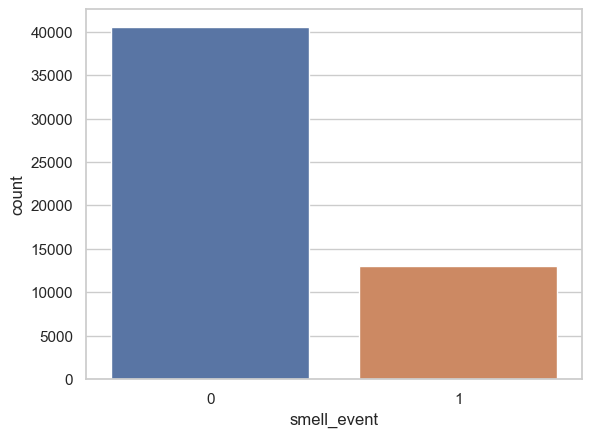

In [35]:
sns.set_theme(style="whitegrid")
sns.countplot(data = df_y, x = "smell_event")

<AxesSubplot:xlabel='smell_event', ylabel='count'>

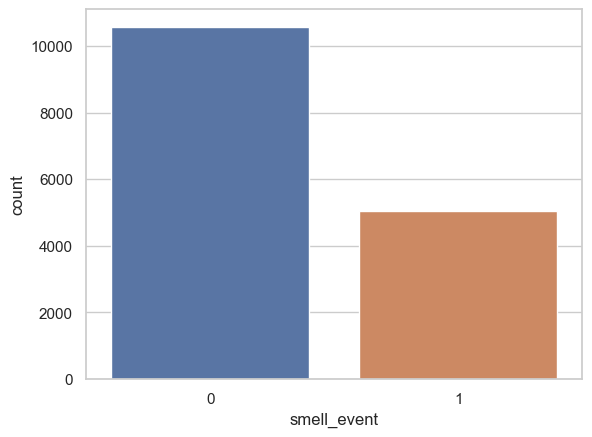

In [36]:
sns.set_theme(style="whitegrid")
sns.countplot(data = df_y_daytime, x = "smell_event")

# Undersampling and oversampling

In [37]:
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=1)
X_train_daytime, X_test_daytime, y_train_daytime, y_test_daytime = train_test_split(df_x_daytime, df_y_daytime, test_size=0.3, random_state=1)

In [38]:
print(y_train['smell_event'].value_counts()[1])
print(y_train['smell_event'].value_counts()[0])

9146
28333


## Undersampling

In [39]:
def create_undersampled_trainset(X_train,y_train):
    rus = RandomUnderSampler(sampling_strategy='majority', random_state=1)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    return X_train, y_train

In [40]:
X_train_US, y_train_US = create_undersampled_trainset(X_train, y_train)

In [41]:
print(y_train_US['smell_event'].value_counts()[1])
print(y_train_US['smell_event'].value_counts()[0])

9146
9146


## Oversampling

In [42]:
def create_oversampled_trainset(X_train,y_train):
    sm = SMOTE(sampling_strategy="minority",random_state=1)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    return X_train, y_train

In [43]:
X_train_OS, y_train_OS = create_oversampled_trainset(X_train,y_train)

In [44]:
print(y_train_OS['smell_event'].value_counts()[1])
print(y_train_OS['smell_event'].value_counts()[0])

28333
28333


## combined under and oversampling

In [45]:
def create_undersampled_and_oversampled_trainset(X_train,y_train):
    over = SMOTE(sampling_strategy="minority",random_state=1)
    under = RandomUnderSampler(sampling_strategy="majority",random_state=1)
    X_train, y_train = over.fit_resample(X_train, y_train)
    X_train, y_train = under.fit_resample(X_train, y_train)
    return X_train, y_train

In [46]:
X_train_combine, y_train_combine = create_undersampled_and_oversampled_trainset(X_train,y_train)

In [47]:
print(y_train_combine['smell_event'].value_counts()[1])
print(y_train_combine['smell_event'].value_counts()[0])

28333
28333


## Training models on undersampled / oversampled datasets

In [48]:
def train_XGB_model(X_train,y_train,X_test,y_test):
    model = XGBClassifier(random_state = 1)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return f1_score(y_test, predictions)

In [49]:
def train_random_forest(X_train,y_train,X_test,y_test):
    model = RandomForestClassifier(random_state = 1)
    model.fit(X_train, np.ravel(y_train))
    predictions = model.predict(X_test)
    return f1_score(y_test, predictions)

In [50]:
score_original_XGB = train_XGB_model(X_train,y_train,X_test,y_test)
score_undersampled_XGB = train_XGB_model(X_train_US,y_train_US,X_test,y_test)
score_oversampled_XGB = train_XGB_model(X_train_OS,y_train_OS,X_test,y_test)
score_combined_XGB = train_XGB_model(X_train_combine,y_train_combine,X_test,y_test)

In [51]:
score_original_RF = train_random_forest(X_train,y_train,X_test,y_test)
score_undersampled_RF = train_random_forest(X_train_US,y_train_US,X_test,y_test)
score_oversampled_RF = train_random_forest(X_train_OS,y_train_OS,X_test,y_test)
score_combined_RF = train_random_forest(X_train_combine,y_train_combine,X_test,y_test)

In [52]:
score_xgb_daytime = train_XGB_model(X_train_daytime,y_train_daytime,X_test_daytime, y_test_daytime)
score_rf_daytime = train_random_forest(X_train_daytime,y_train_daytime,X_test_daytime, y_test_daytime)

In [53]:
score_rf_daytime

0.792542372881356

In [54]:
score_original_XGB

0.7207875588529036

In [55]:
scores_lst = [score_original_XGB,score_undersampled_XGB,score_oversampled_XGB,score_combined_XGB,
              score_original_RF,score_undersampled_RF,score_oversampled_RF,score_combined_RF,
             score_xgb_daytime,score_rf_daytime]
methods = ["Original", "Undersampled", "Oversampled", "Combined","Original", "Undersampled", "Oversampled", "Combined", "Daytime selection", "Daytime selection"]
models = ["XGBoost","XGBoost","XGBoost","XGBoost","Random Forest","Random Forest","Random Forest","Random Forest", "XGBoost", "Random Forest"]

In [56]:
dataframe_scores = {'F1 score':scores_lst,'Method':methods, "Model" :models }
dataframe_scores = pd.DataFrame.from_dict(dataframe_scores)

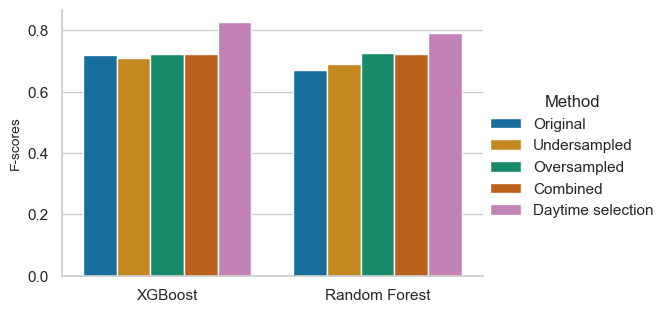

In [57]:
figure = sns.catplot(x="Model",y="F1 score",hue="Method",data=dataframe_scores, kind="bar",aspect=1.5,height = 3.5, palette = "colorblind")
figure.set_axis_labels("", "F-scores", size = 10)


In [86]:
# score_undersampled_XGB / score_original_XGB
# 100* (eindwaarde - beginwaarde)/beginwaarde.

100 * ((score_rf_daytime - score_original_RF) /score_original_RF)

18.302593815996108

In [142]:
0.72/(0.66/100)

109.0909090909091

# Hyperparameter tuning

In [62]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1,log = True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 150),
        'eval_metric': 'logloss',
        "objective" : "binary:logistic"
#         "gamma" : trial.suggest_int("gamma", 10,20)
#         "min_child_weight": trial.suggest_int("min_child_weight", 1, 5)
    }

    optuna_model = XGBClassifier(**params)

    f1 = np.mean(cross_val_score(optuna_model, X_train_daytime, y_train_daytime, scoring="f1", cv = 7))

    return f1

In [177]:
study = optuna.create_study(direction='maximize')

[I 2023-08-12 16:10:43,640] A new study created in memory with name: no-name-76713738-667c-431b-90d1-6665d29aee65


In [179]:
study.optimize(objective, timeout = 600)

[I 2023-08-12 16:13:45,928] Trial 22 finished with value: 0.7956889621796612 and parameters: {'max_depth': 4, 'learning_rate': 0.08840240774490672, 'n_estimators': 149}. Best is trial 22 with value: 0.7956889621796612.
[I 2023-08-12 16:13:54,552] Trial 23 finished with value: 0.7715604703279785 and parameters: {'max_depth': 4, 'learning_rate': 0.026547844893097174, 'n_estimators': 136}. Best is trial 22 with value: 0.7956889621796612.
[I 2023-08-12 16:14:04,400] Trial 24 finished with value: 0.7823622935737387 and parameters: {'max_depth': 4, 'learning_rate': 0.03978180263830477, 'n_estimators': 148}. Best is trial 22 with value: 0.7956889621796612.
[I 2023-08-12 16:14:12,924] Trial 25 finished with value: 0.7942675096597072 and parameters: {'max_depth': 4, 'learning_rate': 0.09811453289259403, 'n_estimators': 133}. Best is trial 22 with value: 0.7956889621796612.
[I 2023-08-12 16:14:20,270] Trial 26 finished with value: 0.7481015452266971 and parameters: {'max_depth': 3, 'learning_rat

[I 2023-08-12 16:20:02,554] Trial 60 finished with value: 0.7866983118793033 and parameters: {'max_depth': 5, 'learning_rate': 0.039783781721213815, 'n_estimators': 116}. Best is trial 48 with value: 0.8043687288082231.
[I 2023-08-12 16:20:14,825] Trial 61 finished with value: 0.7836402980087744 and parameters: {'max_depth': 5, 'learning_rate': 0.029561711925209625, 'n_estimators': 141}. Best is trial 48 with value: 0.8043687288082231.
[I 2023-08-12 16:20:25,897] Trial 62 finished with value: 0.7983050380380253 and parameters: {'max_depth': 5, 'learning_rate': 0.09784772353079722, 'n_estimators': 135}. Best is trial 48 with value: 0.8043687288082231.
[I 2023-08-12 16:20:37,538] Trial 63 finished with value: 0.7919389150652991 and parameters: {'max_depth': 5, 'learning_rate': 0.047255133733182686, 'n_estimators': 136}. Best is trial 48 with value: 0.8043687288082231.
[I 2023-08-12 16:20:48,284] Trial 64 finished with value: 0.795838006846547 and parameters: {'max_depth': 5, 'learning_ra

In [158]:
joblib.dump(study, 'XGBoost_daytime_optuna.pkl')

['XGBoost_daytime_optuna.pkl']

In [15]:
data = joblib.load('XGBoost_daytime_optuna.pkl')

In [16]:
fig = plot_optimization_history(data)
fig.show()

In [119]:
print('Number of finished trials: {}'.format(len(data.trials)))
print('Best trial:')
trial = data.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 7
Best trial:
  Value: 0.8188933989037643
  Params: 
    max_depth: 18
    learning_rate: 0.04895367368228852
    n_estimators: 408


In [160]:
params = trial.params

In [161]:
model_XGBoost = XGBClassifier(**params)
model_XGBoost.fit(X_train_daytime, y_train_daytime)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04895367368228852,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=18, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=408, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [64]:
filename = "smell_event_prediction_XGBoost.sav"
# dump([model_XGBoost, X_train_daytime, X_test_daytime, y_train_daytime, y_test_daytime], open(filename, 'wb'))

In [98]:
filename = "smell_event_prediction_XGBoost.sav"
modelxgb, X_train, X_test, y_train, y_test = load(open(filename, 'rb')) 

In [99]:
y_pred = modelxgb.predict(X_test)

In [100]:
F1_score = f1_score(y_test, y_pred)

In [101]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      3132
           1       0.87      0.80      0.83      1554

    accuracy                           0.89      4686
   macro avg       0.89      0.87      0.88      4686
weighted avg       0.89      0.89      0.89      4686



In [102]:
F1_score

0.832385413181666

In [69]:
def objective(trial):
    """Define the objective function"""

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100,150),
        'min_samples_split': trial.suggest_int('min_samples_split', 2,5),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1,5)
    }

    optuna_model = RandomForestClassifier(**params, random_state = 1, max_features = "sqrt", bootstrap = True)

    f1 = np.mean(cross_val_score(optuna_model, X_train, np.ravel(y_train), scoring="f1", cv = 7))
    
    return f1

In [71]:
study_RF = optuna.create_study(direction='maximize')
study_RF.optimize(objective, timeout=600)

In [77]:
data = joblib.load('RF_2_daytime.pkl')
params_RF = data.best_params

In [78]:
params_RF

{'n_estimators': 148, 'min_samples_split': 4, 'min_samples_leaf': 1}

In [17]:
fig = plot_optimization_history(data2)
fig.show()

In [80]:
model = RandomForestClassifier(**params_RF)
model_result = model.fit(X_train, np.ravel(y_train))


y_pred = model_result.predict(X_test)
F1_score = f1_score(y_test, y_pred)
F1_score

0.7981029810298103

## SHAPLEY

In [105]:
X_train = X_train.rename(columns={"3.feed_28.SONICWS_MPH_pre_1h": "Windspeed Liberty P1",
                                  "3.feed_26.SONICWS_MPH_pre_1h": "Windspeed Lawrenceville P1",
                                 "3.feed_11067.SONICWS_MPH..3.feed_43.SONICWS_MPH_pre_1h":"Windspeed Parkway East P1",
                                 "3.feed_24.PM10_UG_M3_pre_1h":"PM10 Glassport High Street P1",
                                 "3.feed_11067.SONICWD_DEG..3.feed_43.SONICWD_DEG_sine_pre_1h":"Wind direction Parkway East P1",
                                 "3.feed_26.SONICWD_DEG_sine_pre_1h":"Wind direction Lawrenceville P1",
                                  "3.feed_3.SONICWS_MPH_pre_1h":"Windspeed North Braddock P1",
                                  "hour_of_day_sine":"Hour of day",
                                  "3.feed_26.OZONE_PPM_pre_1h":"Ozone Lawrenceville P1",
                                  "3.feed_1.SIGTHETA_DEG_pre_3h":"Windspeed Avalon P3",
                                "3.feed_28.H2S_PPM_pre_1h": "Hydrogen sulfide Liberty P1",
                                  "3.feed_3.SONICWD_DEG_sine_pre_1h": "Wind direction North Baddock P1"
                                 })

In [106]:
X_test = X_test.rename(columns={"3.feed_28.SONICWS_MPH_pre_1h": "Windspeed Liberty P1",
                                  "3.feed_26.SONICWS_MPH_pre_1h": "Windspeed Lawrenceville P1",
                                 "3.feed_11067.SONICWS_MPH..3.feed_43.SONICWS_MPH_pre_1h":"Windspeed Parkway East P1",
                                 "3.feed_24.PM10_UG_M3_pre_1h":"PM10 Glassport High Street P1",
                                 "3.feed_11067.SONICWD_DEG..3.feed_43.SONICWD_DEG_sine_pre_1h":"Wind direction Parkway East P1",
                                 "3.feed_26.SONICWD_DEG_sine_pre_1h":"Wind direction Lawrenceville P1",
                                  "3.feed_3.SONICWS_MPH_pre_1h":"Windspeed North Braddock P1",
                                  "hour_of_day_sine":"Hour of day",
                                  "3.feed_26.OZONE_PPM_pre_1h":"Ozone Lawrenceville P1",
                                  "3.feed_1.SIGTHETA_DEG_pre_3h":"Windspeed Avalon P3",
                                "3.feed_28.H2S_PPM_pre_1h": "Hydrogen sulfide Liberty P1",
                                "3.feed_3.SONICWD_DEG_sine_pre_1h": "Wind direction North Baddock P1"
                                 })

In [107]:
import shap
explainer = shap.TreeExplainer(modelxgb, feature_names=X_train.columns)
shap_values = explainer(X_train)

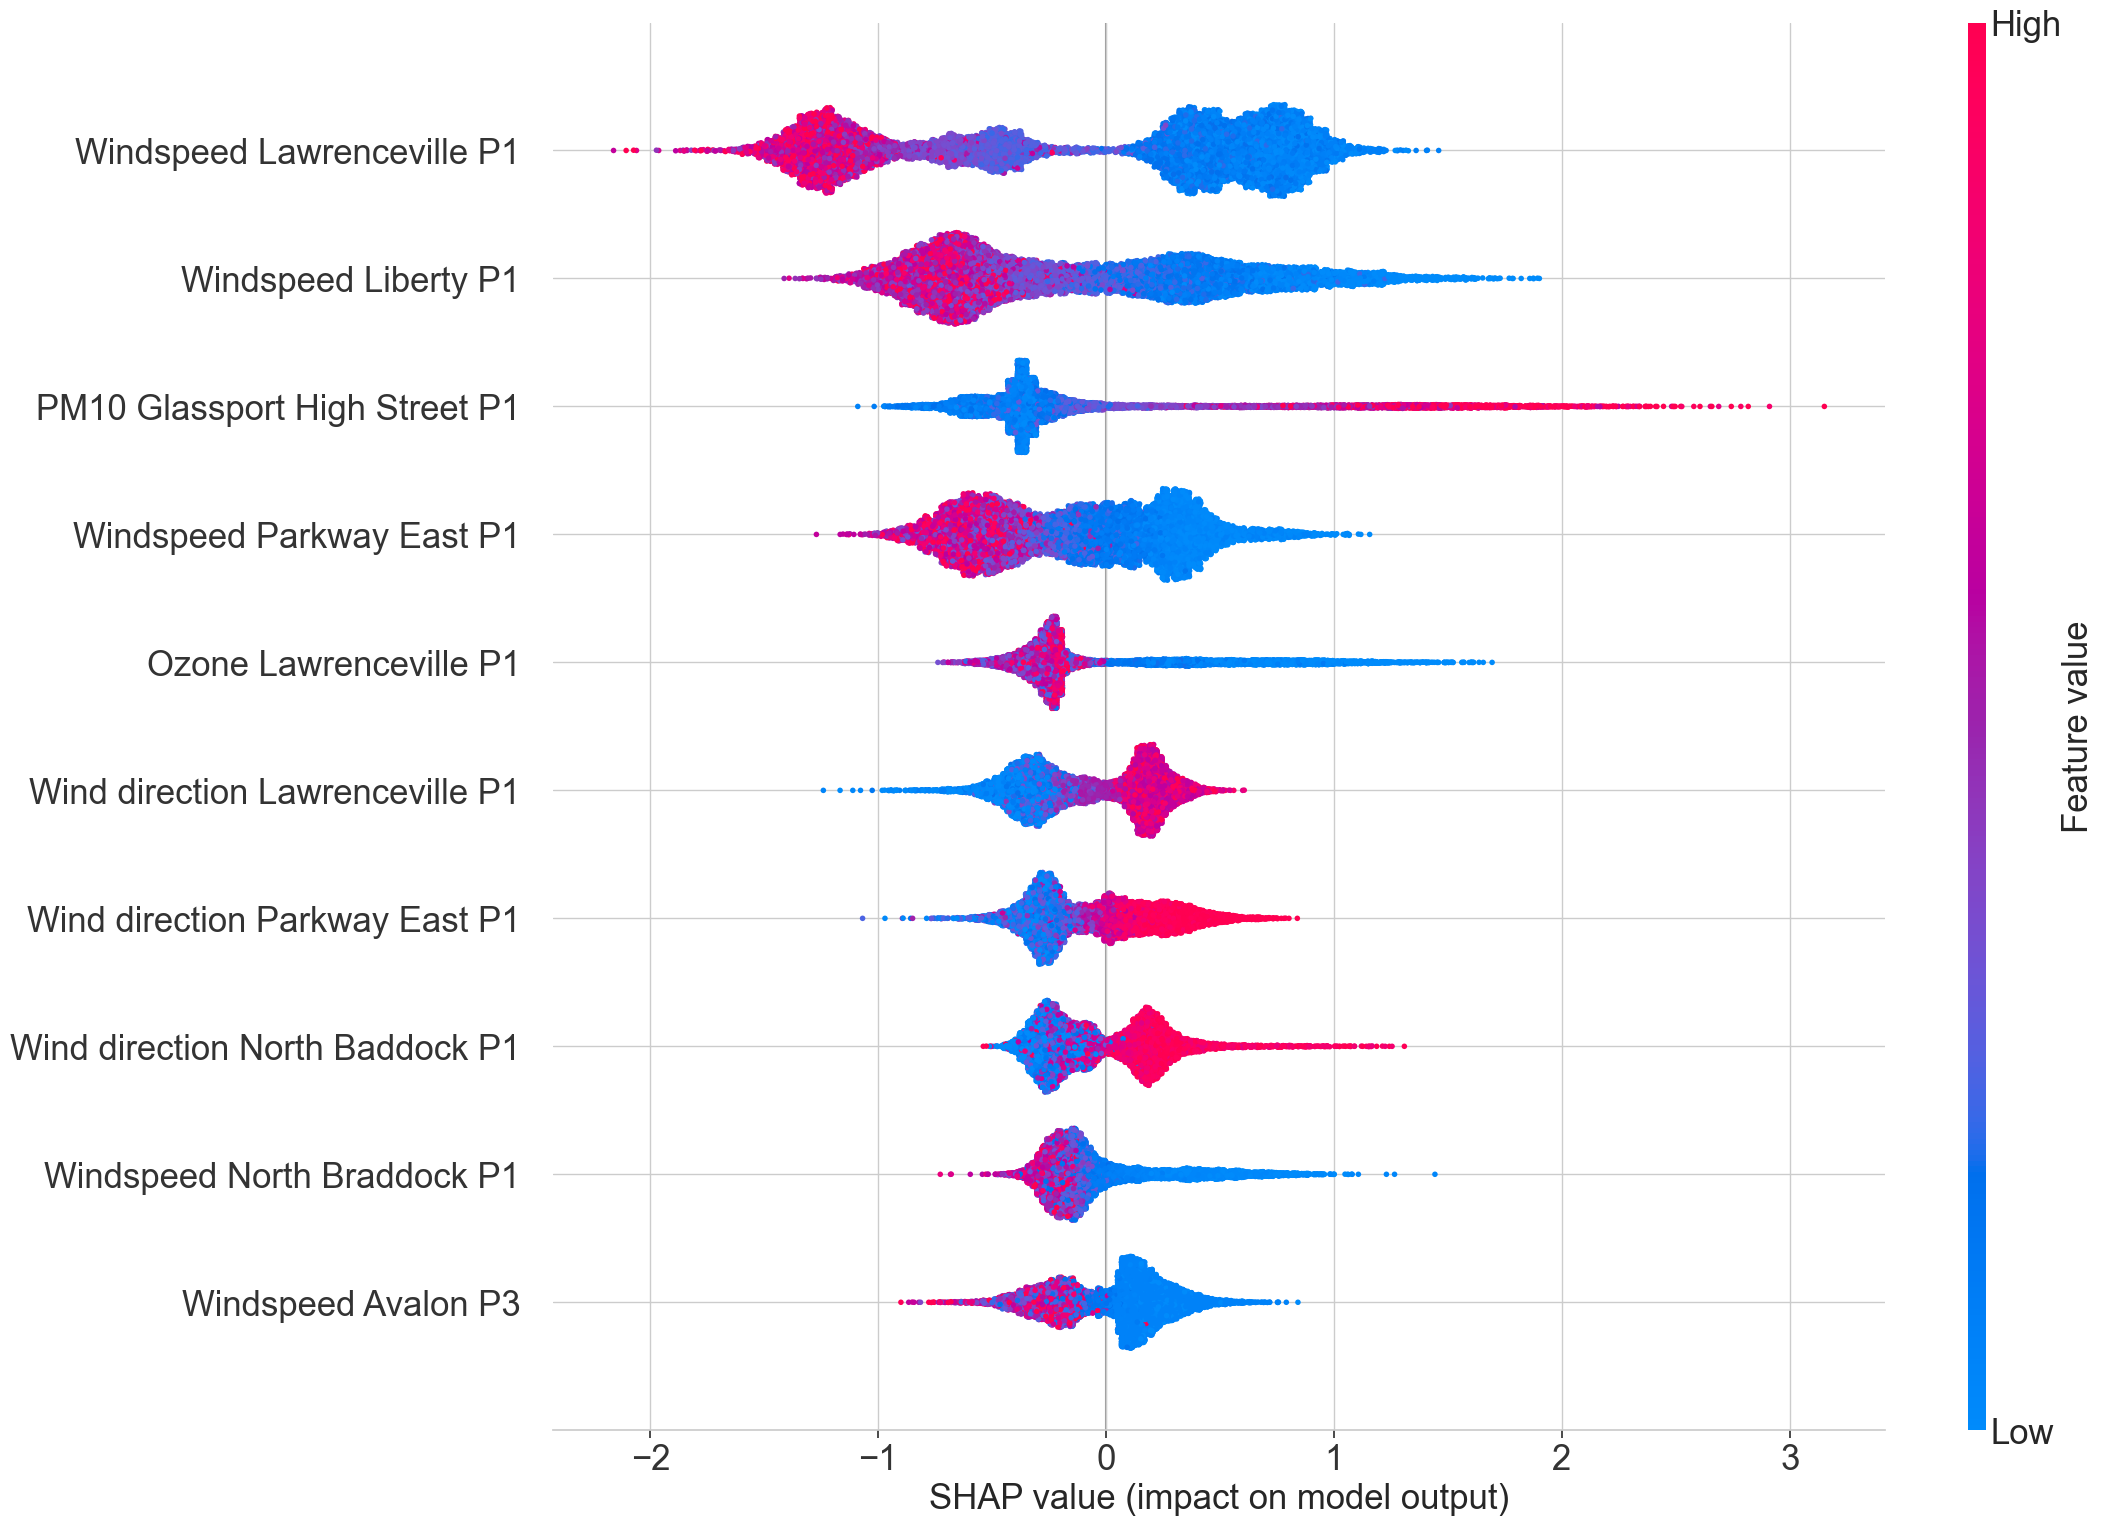

In [116]:
# https://github.com/shap/shap/issues/594
shap.summary_plot(shap_values, X_train,plot_size=(20,15),max_display = 10,show = False)

fig, ax = plt.gcf(), plt.gca()
ax.tick_params(labelsize=25)
ax.set_xlabel("SHAP value (impact on model output)", fontsize=25)

# Get colorbar
cb_ax = fig.axes[1] 

# Modifying color bar parameters
cb_ax.tick_params(labelsize=25)
cb_ax.set_ylabel("Feature value", fontsize=25)

plt.show()

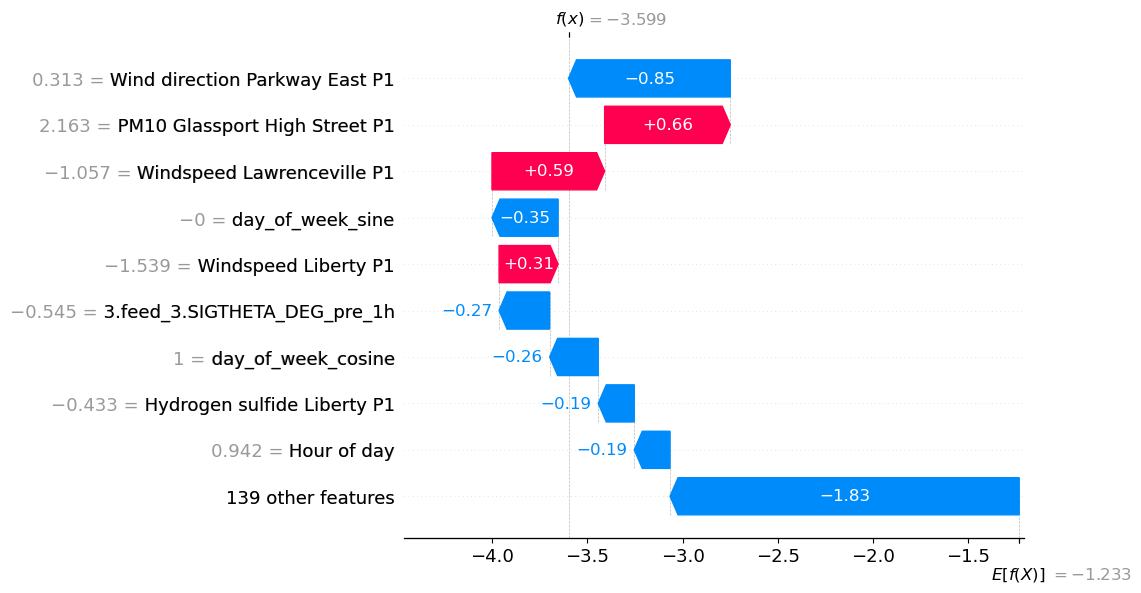

In [14]:
shap.plots.waterfall(shap_values[0])

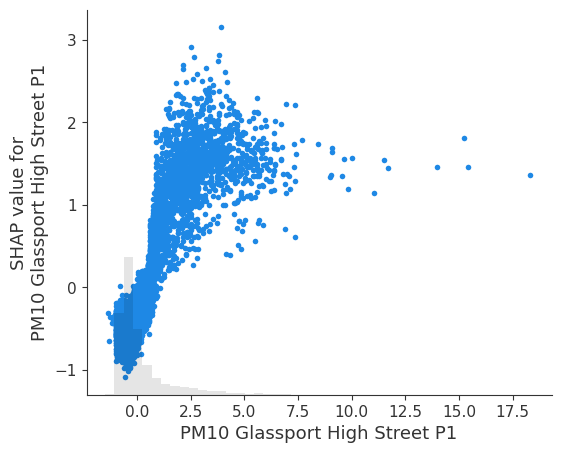

In [15]:
# maximum impact
shap.plots.scatter(shap_values[:, shap_values.abs.max(0).argsort[-1]]) # absolute is PM


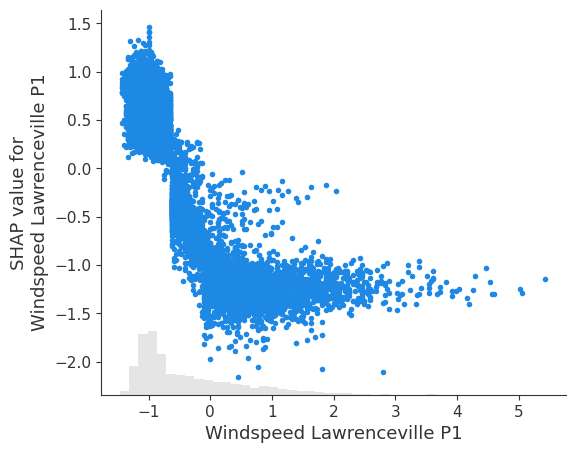

In [16]:
# average impact
shap.plots.scatter(shap_values[:, shap_values.abs.mean(0).argsort[-1]])

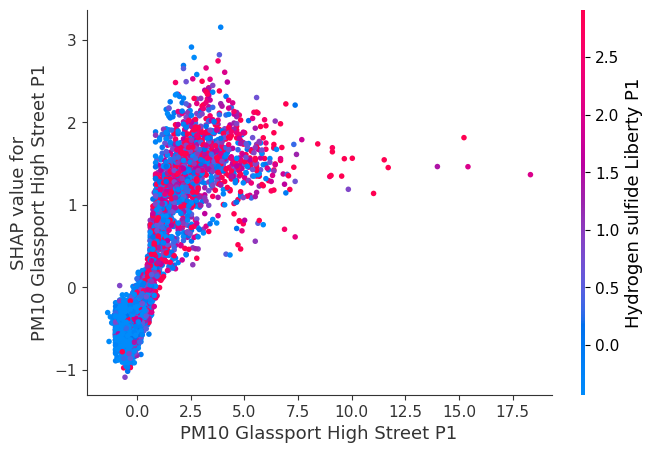

In [28]:
shap.dependence_plot("rank(2)", shap_values.values, X_train, interaction_index="Hydrogen sulfide Liberty P1")

In [78]:
# inds = shap.utils.potential_interactions(shap_values[:, "3.feed_28.SONICWS_MPH_pre_1h"], shap_values)

# for i in range(3):
#     shap.plots.scatter(shap_values[:,"3.feed_28.SONICWS_MPH_pre_1h"], color=shap_values[:,inds[i]])

In [18]:
corr_matrix = X_train.corrwith(X_train["3.feed_24.PM10_UG_M3_pre_1h"],method = "pearson")
sorted_matrix = corr_matrix.sort_values(ascending = False)
sorted_matrix.head(20)

3.feed_24.PM10_UG_M3_pre_1h                               1.000000
3.feed_24.PM10_UG_M3_pre_2h                               0.850103
3.feed_24.PM10_UG_M3_pre_3h                               0.732284
3.feed_29.PM10_UG_M3_pre_1h                               0.637672
3.feed_29.PM25_UG_M3..3.feed_29.PM25T_UG_M3_pre_1h        0.616609
3.feed_29.PM10_UG_M3_pre_2h                               0.606410
3.feed_3508.PM2_5_pre_1h                                  0.605682
3.feed_29.PM25_UG_M3..3.feed_29.PM25T_UG_M3_pre_2h        0.596376
3.feed_29.PM10_UG_M3_pre_3h                               0.582503
3.feed_3508.PM2_5_pre_2h                                  0.579186
3.feed_29.PM25_UG_M3..3.feed_29.PM25T_UG_M3_pre_3h        0.573037
3.feed_3508.PM2_5_pre_3h                                  0.564604
3.feed_11067.PM25T_UG_M3..3.feed_43.PM25T_UG_M3_pre_1h    0.520277
3.feed_5975.PM2_5_pre_1h                                  0.518563
3.feed_23.PM10_UG_M3_pre_1h                               0.49

In [86]:
corr_matrix = X_train.corrwith(X_train["Ozone Lawrenceville P1"],method = "pearson")
sorted_matrix = corr_matrix.sort_values(ascending = False)
sorted_matrix.head(20)

Ozone Lawrenceville P1                                    1.000000
3.feed_3506.OZONE_pre_1h                                  0.991959
3.feed_26.OZONE_PPM_pre_2h                                0.955747
3.feed_3506.OZONE_pre_2h                                  0.949134
3.feed_26.OZONE_PPM_pre_3h                                0.890407
3.feed_3506.OZONE_pre_3h                                  0.884849
3.feed_26.SONICWS_MPH_pre_2h                              0.591855
3.feed_26.SONICWS_MPH_pre_3h                              0.587196
Windspeed Lawrenceville P1                                0.577397
3.feed_28.SONICWS_MPH_pre_3h                              0.556080
3.feed_28.SONICWS_MPH_pre_2h                              0.555106
3.feed_3.SONICWS_MPH_pre_3h                               0.540451
Windspeed Liberty P1                                      0.538646
3.feed_3.SONICWS_MPH_pre_2h                               0.536728
3.feed_11067.SONICWS_MPH..3.feed_43.SONICWS_MPH_pre_2h    0.52

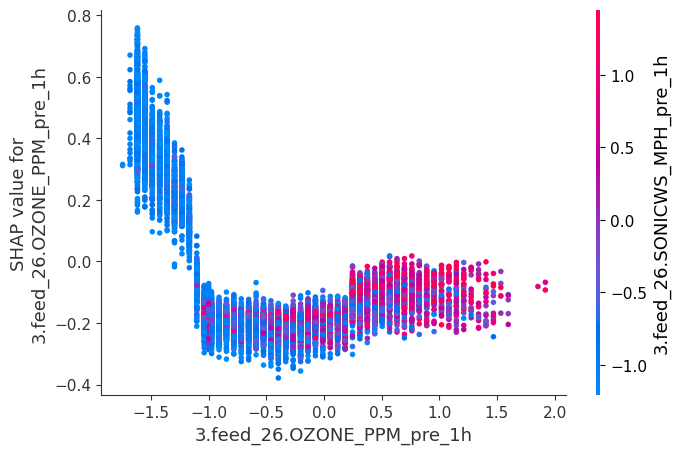

In [24]:
shap.dependence_plot("rank(8)", shap_values.values, X_train, interaction_index="3.feed_26.SONICWS_MPH_pre_1h")